## 1. Definition of computational parameters

In [1]:
import os
import sys
import shutil
import re
import math
import subprocess
import nglview as nv
import pytraj as pt

#insert path to python scripts
sys.path.insert(1, os.environ['BASE'] + "/modules")

from draw_2d import *
from draw_3d import drawit
from tqdm.notebook import tqdm

from molvs import Standardizer

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import SDWriter
from rdkit.Chem import AllChem
from rdkit.Chem import MolFromSmarts
from rdkit.Chem import rdmolops
from rdkit.Chem import rdchem

from convert import *
from plot_graph import *

In [2]:
#number of configurations to generate in basic energy minimization
numc = 50

#use podman
gromacs_s = "/opt/podman-run.py gromacs -p" #gmx_mpi
gromacs_d = "/opt/podman-run.py gromacs -p -d" #double precision gromacs
orca = "/opt/podman-run.py orca -p"
#use docker
#gromacs_s = "/opt/gmx-docker" #gmx_mpi
#gromacs_d = "/opt/gmx-docker -d" #double precision gromacs
#orca = "/opt/orca-docker"

plumed = gromacs_s
orca_job_check = "/home/base/modules/orcajobcheck.py"
xyz_to_mol = "/home/base/modules/xyz2mol/xyz2mol.py"

#specify number of abailable cpu's to be used in evaluations (maximum possible on machine by default)
num_of_cpus = os.environ['CPUS']

## 2. Molecule shape processing

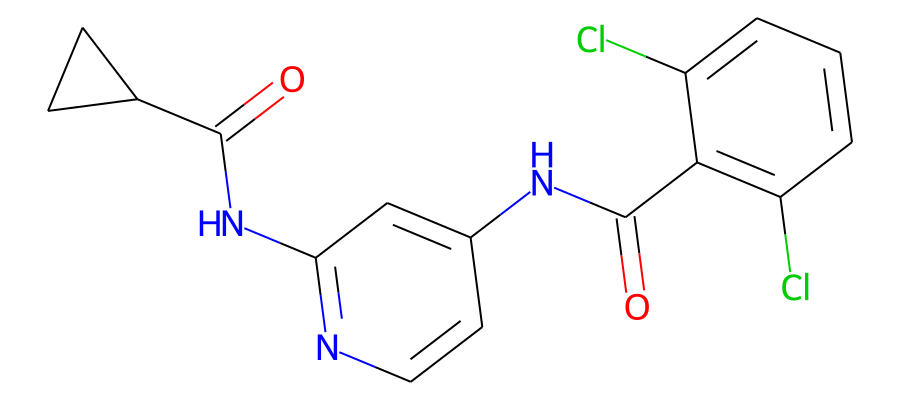

In [3]:
#specify input of desired molecule in SMILES
smiles_molecule = "O=C(Nc1nccc(c1)NC(=O)c2c(Cl)cccc2Cl)C3CC3"

molecule = Chem.MolFromSmiles(smiles_molecule)

render_svg(moltosvg(molecule))

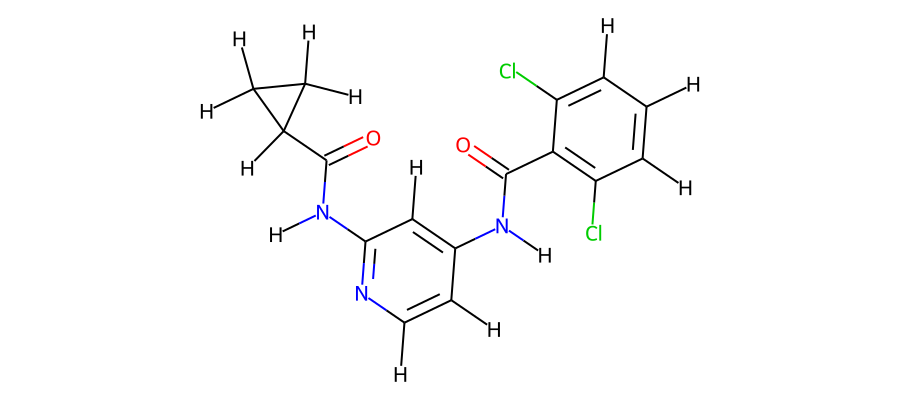

In [4]:
with open("molekula.smi", "w") as smifile:
    smifile.write(smiles_molecule)
    
s = Standardizer()
molecule = s.standardize(molecule)
molecule = Chem.AddHs(molecule)
natoms = molecule.GetNumAtoms()
charge = Chem.rdmolops.GetFormalCharge(molecule)

render_svg(moltosvg(molecule))

In [5]:
#set lowest energy configuration

#set default id of minimal energy conformer to -1
minid = -1
#set default minimal energy to highest possible float number
minene = sys.float_info.max

AllChem.EmbedMultipleConfs(molecule, clearConfs=True, numConfs=numc)
#run 'MMFF94 force field' energy evaluation
done = AllChem.MMFFOptimizeMoleculeConfs(molecule)

for i in range(len(done)):
    if done[i][1]<minene:
        minene = done[i][1]
        minid = i
print(f'Minimal energy: {minene}')

writer = SDWriter("molekula.mol")
writer.write(molecule, confId=minid)

drawit(molecule)

Minimal energy: -24.83560640003078


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [6]:
#set pattern to detect torsion angles

RotatableBond = Chem.MolFromSmarts('[!$([NH]!@C(=O))&!D1&!$(*#*)&!$([C;H3])&!$([O;H1])&!$([N;H3])]-&!@[!$([NH]!@C(=O))&!D1&!$(*#*)&!$([C;H3])&!$([O;H1])&!$([N;H3])]')
rotatables = molecule.GetSubstructMatches(RotatableBond)
print(rotatables)

((1, 20), (10, 12))


In [7]:
#get numbers of atoms that form torsion angles

torsions = []
for rotatable in rotatables:
    pairs1 = []
    pairs2 = []
    for bond in molecule.GetBonds():
        if rotatable[0]==bond.GetBeginAtomIdx() and rotatable[1]!=bond.GetEndAtomIdx():
            pairs1.append([bond.GetBeginAtomIdx(),bond.GetEndAtomIdx()])
        if rotatable[1]==bond.GetBeginAtomIdx() and rotatable[0]!=bond.GetEndAtomIdx():
            pairs2.append([bond.GetBeginAtomIdx(),bond.GetEndAtomIdx()])
    torsions.append([pairs1[0][1],pairs1[0][0],pairs2[0][0],pairs2[0][1]])
print(torsions)

[[2, 1, 20, 21], [11, 10, 12, 13]]


## 3. Preparation of environment and molecule

In [8]:
# prepare input files for energetic minimization

netcharge = rdmolops.GetFormalCharge(molecule)
!antechamber -i molekula.mol -fi mdl -o molekula.prepi -fo prepi -c bcc -nc {netcharge} && \
parmchk2 -i molekula.prepi -f prepi -o molekula.frcmod && \
tleap -f tleapin.txt && \
acpype -p molekula.prmtop -x molekula.inpcrd


Welcome to antechamber 19.0: molecular input file processor.

acdoctor mode is on: check and diagnose problems in the input file.
-- Check Format for mdl File --
   Status: pass
-- Check Unusual Elements --
   Status: pass
-- Check Open Valences --
   Status: pass
-- Check Geometry --
      for those bonded   
      for those not bonded   
   Status: pass
-- Check Weird Bonds --
   Status: pass
-- Check Number of Units --
   Status: pass
acdoctor mode has completed checking the input file.

Info: Total number of electrons: 180; net charge: 0

Running: /opt/intelpython3/bin/sqm -O -i sqm.in -o sqm.out

-I: Adding /opt/intelpython3/dat/leap/prep to search path.
-I: Adding /opt/intelpython3/dat/leap/lib to search path.
-I: Adding /opt/intelpython3/dat/leap/parm to search path.
-I: Adding /opt/intelpython3/dat/leap/cmd to search path.
-f: Source tleapin.txt.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./tleapin.txt
----- Source: /opt/intelpython3/dat/leap/cmd/leaprc.gaff
----- 

In [9]:
#fix ordering of atoms

order_before = []
order_after = []

with open('sqm.pdb','r') as pdbfile:
    for atom in pdbfile.readlines():
        order_before.append(atom.split()[2])
        
with open('MOL_GMX.gro','r') as grofile:
    for atom in grofile.readlines():
        if atom.startswith('    1  MOL'):
            order_after.append(atom.split()[2])

torsions_new = []
torsion_new = []
for torsion in torsions:
    for i in torsion:       
        torsion_new.append(order_after.index(order_before[i])+1)
    torsions_new.append(torsion_new)
    torsion_new = []
torsions = torsions_new
print(torsions)

[[25, 27, 29, 31], [13, 12, 11, 9]]


In [10]:
!mkdir em
with open("em/em.mdp", "w") as emfile:
    emfile.write("integrator          =  steep\n")
    emfile.write("nsteps              =  100000\n")
    emfile.write("emtol               =  0\n")
    emfile.write("emstep              =  0.1\n")
    emfile.write("nstcomm             =  1\n")
    emfile.write("nstxout             =  100\n")
    emfile.write("nstvout             =  100\n")
    emfile.write("nstfout             =  0\n")
    emfile.write("nstlog              =  100\n")
    emfile.write("nstenergy           =  100\n")
    emfile.write("nstlist             =  1\n")
    emfile.write("ns_type             =  grid\n")
    emfile.write("coulombtype         =  cut-off\n")
    emfile.write("rlist               =  1.4\n")
    emfile.write("rcoulomb            =  1.4\n")
    emfile.write("rvdw                =  1.4\n")
    emfile.write("energygrps          =  System\n")
    emfile.write("epsilon-r           =  80\n")
    emfile.write("\n")
shutil.copy("MOL_GMX.gro", "em/")
shutil.copy("MOL_GMX.top", "em/")

mkdir: cannot create directory ‘em’: File exists


'em/MOL_GMX.top'

In [11]:
!{gromacs_s} -w /em -- editconf -f MOL_GMX -o box -c -box 3 3 3 && \
{gromacs_s} -w /em -- grompp -f em.mdp -c box -p MOL_GMX -o em1 && \
{gromacs_d} -w /em -- mdrun -deffnm em1 -ntomp 2 

b'done'
b'done'
b'done'


In [12]:
#prepare files for getting the molecule to dynamic state

!mkdir md
with open("md/md.mdp", "w") as mdfile:
    mdfile.write("integrator          = sd\n")
    mdfile.write("nsteps              = 100000\n")
    mdfile.write("dt                  = 0.001\n")
    mdfile.write("nstxout             = 1000\n")
    mdfile.write("nstvout             = 1000\n")
    mdfile.write("nstenergy           = 1000\n")
    mdfile.write("nstlog              = 1000\n")
    mdfile.write("continuation        = no\n")
    mdfile.write("constraints         = none\n")
    mdfile.write("cutoff-scheme       = Verlet\n")
    mdfile.write("ns_type             = grid\n")
    mdfile.write("nstlist             = 1\n")
    mdfile.write("rlist               = 1.4\n")
    mdfile.write("rcoulomb            = 1.4\n")
    mdfile.write("rvdw                = 1.4\n")
    mdfile.write("coulombtype         = cut-off\n")
    mdfile.write("tcoupl              = V-rescale\n")
    mdfile.write("tc-grps             = system\n")
    mdfile.write("tau_t               = 0.1\n")
    mdfile.write("ref_t               = 300\n")
    mdfile.write("pcoupl              = no\n")
    mdfile.write("pbc                 = xyz\n")
    mdfile.write("gen_vel             = yes\n")
    mdfile.write("epsilon-r           = 80\n")
    mdfile.write("\n")
shutil.copy("em/em1.gro", "md/")
shutil.copy("MOL_GMX.top", "md/")

mkdir: cannot create directory ‘md’: File exists


'md/MOL_GMX.top'

In [13]:
!{gromacs_s} -w /md -- grompp -f md.mdp -c em1 -p MOL_GMX -o md1 && \
{gromacs_d} -w /md -- mdrun -deffnm md1 -ntomp 2

b'done'
b'done'


In [14]:
#show trajectory of conformations
#select group for trjconv evaluation
#Group     0 (         System)
#Group     1 (          Other)
#Group     2 (            MOL)
group = 0

!{gromacs_s} -i {group} -w /md -- trjconv -s md1.tpr -f md1.trr -o outTraj.pdb

traj = pt.load('md/outTraj.pdb')
view = nv.show_pytraj(traj)
view

b'done'


NGLWidget(max_frame=100)

In [15]:
#fix periodic boundaries errors when the molecule jumps out of the box
#select group for trjconv evaluation
#Group     0 (         System)
#Group     1 (          Other)
#Group     2 (            MOL)
group = 1

for i in tqdm(range(len(torsions))):
  fr = str(float(100-len(torsions)+i)-0.01)
  to = str(float(100-len(torsions)+i)+0.01)
  !{gromacs_s} -i {group} -w /md -- trjconv -pbc nojump -s md1 -f md1 -o frame{i}.gro -b {fr} -e {to}<<EOF\n0\nEOF

b'done'
b'done'



## 4. Generation of representative configurations
### 4.1 Trajectory generation

In [16]:
!mkdir mtd
with open("mtd/mtd.mdp", "w") as mtdfile:
    mtdfile.write("integrator          = sd\n")
    mtdfile.write("nsteps              = 10000000\n") #10 ns each replica
    mtdfile.write("dt                  = 0.001\n")
    mtdfile.write("nstxout             = 10000\n") # output coordinates every 10ps to *.trr
    mtdfile.write("nstvout             = 10000\n") # output velocities every 10ps to *.trr
    mtdfile.write("nstenergy           = 1000\n")
    mtdfile.write("nstlog              = 1000\n")
    mtdfile.write("continuation        = no\n")
    mtdfile.write("constraints         = none\n")
    mtdfile.write("cutoff-scheme       = Verlet\n")
    mtdfile.write("ns_type             = grid\n")
    mtdfile.write("nstlist             = 1\n")
    mtdfile.write("rlist               = 1.4\n")
    mtdfile.write("rcoulomb            = 1.4\n")
    mtdfile.write("rvdw                = 1.4\n")
    mtdfile.write("coulombtype         = cut-off\n")
    mtdfile.write("tcoupl              = V-rescale\n")
    mtdfile.write("tc-grps             = system\n")
    mtdfile.write("tau_t               = 0.1\n")
    mtdfile.write("ref_t               = 300\n")
    mtdfile.write("pcoupl              = no\n")
    mtdfile.write("pbc                 = xyz\n")
    mtdfile.write("gen_vel             = yes\n")
    mtdfile.write("epsilon-r           = 80\n")
    mtdfile.write("\n")

mkdir: cannot create directory ‘mtd’: File exists


In [17]:
for i in range(len(torsions)):
    if not os.path.exists("mtd/w{}".format(i)):
        !mkdir mtd/w{i}
    with open("mtd/w{}/plumed.dat".format(i), "w") as plumeddat:
        plumeddat.write("RANDOM_EXCHANGES\n")
        plumeddat.write("WHOLEMOLECULES ENTITY0=1-{}\n".format(natoms))
        for j in range(len(torsions)):
            plumeddat.write("TORSION ATOMS={},{},{},{} LABEL=cv{}\n".format(torsions[j][0],torsions[j][1],torsions[j][2],torsions[j][3],j+1))
        plumeddat.write("METAD ARG=cv{} HEIGHT=0.5 SIGMA=0.3 PACE=1000 GRID_MIN=-pi GRID_MAX=pi BIASFACTOR=15 LABEL=be\n".format(i+1))
        cvs = ""
        for j in range(len(torsions)):
            cvs=cvs+"cv{},".format(j+1)
        cvs = cvs[:-1]
        plumeddat.write("PRINT ARG={} STRIDE=1000 FILE=COLVAR\n".format(cvs))
        plumeddat.write("PRINT ARG=be.bias STRIDE=1000 FILE=BIAS\n")

shutil.copy("MOL_GMX.top", "mtd/")

'mtd/MOL_GMX.top'

In [18]:
for i in tqdm(range(len(torsions))):
    shutil.copy("md/frame{}.gro".format(i), "mtd/w{}/".format(i))
    !{gromacs_s} -w /mtd -- grompp -f mtd.mdp -c w{i}/frame{i} -p MOL_GMX -o w{i}/mtd1

b'done'
b'done'



In [19]:
directories = ""
for i in range(len(torsions)):
    directories = directories + "w{} ".format(i)

!{gromacs_d} -n {len(torsions)} -w /mtd -- mdrun -g llog -ntomp 1 -deffnm mtd1 -replex 500 -plumed plumed.dat -multidir {directories}

b'done'


### 4.2 Configurations clustering

In [ ]:
#select groups for cluster evaluation
#Group     0 (         System)
#Group     1 (          Other)
#Group     2 (            MOL)
#Group     3 (         Custom)
groups = "30"
!mkdir clustering -m 757 ; mkdir -m 757 clustering/outClustersPDB ; mkdir -m 757 clustering/outClustersXYZ ; mkdir -m 757 clustering/outClusters

trajectories = ""
for i in range(len(torsions)):
    trajectories = trajectories + "mtd/w{}/mtd1.trr ".format(i)

#concatinate trajectories    
!{gromacs_s} trjcat -f {trajectories} -cat -o mtd/mtd1.trr
#make index file with non-hydrogen atoms, use 1 & ! a H* and q for input
!{gromacs_s} -m '"1&!aH*_q"' -- make_ndx -f md/md1.tpr -o mtd/index.ndx
#include index file and select index group 3
!{gromacs_s} -i {groups} -- cluster -method gromos -f mtd/mtd1.trr -s mtd/w0/mtd1.tpr -n mtd/index.ndx -cutoff 0.15 -cl clustering/outCluster.pdb


#divide all clusters from gmx cluster to single clusters
with open("clustering/outCluster.pdb") as input_cluster:
    i = 0
    outFile = open("clustering/outClustersPDB/outCluster{}.pdb".format(i), "w")
    for line in input_cluster:
        if line != "ENDMDL\n":
            outFile.write(line)
            continue
        outFile.write("ENDMDL\n")
        i += 1
        outFile.close()
        outFile = open("clustering/outClustersPDB/outCluster{}.pdb".format(i), "w")
!rm clustering/outClustersPDB/outCluster{i}.pdb
clusters_ids = [x for x in range(0, i)]


#convert .pdb clusters to .xyz
for pdb_cluster in tqdm(os.listdir("clustering/outClustersPDB/")):
    !babel -ipdb clustering/outClustersPDB/{pdb_cluster} -oxyz clustering/outClustersXYZ/{pdb_cluster.replace("pdb", "xyz")}
    
#compute landmarks coordinations and plumed.dat
!parmtSNEcv -i mtd/mtd1.trr -p clustering/outClustersPDB/outCluster0.pdb -boxx 3 -boxy 3 -boxz 3 -dim 2 -nofit True -layers 2 -o landmarks.txt -plumed plumed.dat -epochs 2000

mkdir: cannot create directory ‘clustering’: File exists
mkdir: cannot create directory ‘clustering/outClustersPDB’: File exists
mkdir: cannot create directory ‘clustering/outClustersXYZ’: File exists
mkdir: cannot create directory ‘clustering/outClusters’: File exists
b'done'
b'done'
b'done'


*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 35)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 36)
1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 29)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 30)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 31)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 32)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 33)
*** O

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

0 molecules converted
2 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a 

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

1 molecule converted
36 warnings 13 audit log messages 
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problem

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 1)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 2)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 3)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found '  ' (atom 4)
*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PD


2020-11-25 12:26:16.610168: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intelpython3/lib/libfabric:
2020-11-25 12:26:16.610247: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2020-11-25 12:26:18.429541: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intelpython3/lib/libfabric:
2020-11-25 12:26:18.429613: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2020-11-25 12:26:18.429653: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3be7dc2c4283): /pro

Epoch: 146/2000, loss: 2.1864306926727295
Epoch: 147/2000, loss: 2.1859421730041504
Epoch: 148/2000, loss: 2.1854541301727295
Epoch: 149/2000, loss: 2.184967279434204
Epoch: 150/2000, loss: 2.184481620788574
Epoch: 151/2000, loss: 2.1839962005615234
Epoch: 152/2000, loss: 2.1835129261016846
Epoch: 153/2000, loss: 2.1830296516418457
Epoch: 154/2000, loss: 2.1825473308563232
Epoch: 155/2000, loss: 2.182067394256592
Epoch: 156/2000, loss: 2.181586742401123
Epoch: 157/2000, loss: 2.181107521057129
Epoch: 158/2000, loss: 2.1806302070617676
Epoch: 159/2000, loss: 2.1801536083221436
Epoch: 160/2000, loss: 2.1796789169311523
Epoch: 161/2000, loss: 2.1792051792144775
Epoch: 162/2000, loss: 2.1787331104278564
Epoch: 163/2000, loss: 2.17826247215271
Epoch: 164/2000, loss: 2.1777923107147217
Epoch: 165/2000, loss: 2.1773245334625244
Epoch: 166/2000, loss: 2.1768577098846436
Epoch: 167/2000, loss: 2.1763906478881836
Epoch: 168/2000, loss: 2.1759250164031982
Epoch: 169/2000, loss: 2.1754603385925293

Epoch: 344/2000, loss: 1.9699602127075195
Epoch: 345/2000, loss: 1.967997670173645
Epoch: 346/2000, loss: 1.9660418033599854
Epoch: 347/2000, loss: 1.9640902280807495
Epoch: 348/2000, loss: 1.9621423482894897
Epoch: 349/2000, loss: 1.960195541381836
Epoch: 350/2000, loss: 1.9582488536834717
Epoch: 351/2000, loss: 1.9563015699386597
Epoch: 352/2000, loss: 1.9543514251708984
Epoch: 353/2000, loss: 1.9524006843566895
Epoch: 354/2000, loss: 1.9504444599151611
Epoch: 355/2000, loss: 1.9484870433807373
Epoch: 356/2000, loss: 1.9465214014053345
Epoch: 357/2000, loss: 1.9445488452911377
Epoch: 358/2000, loss: 1.942564845085144
Epoch: 359/2000, loss: 1.9405691623687744
Epoch: 360/2000, loss: 1.9385554790496826
Epoch: 361/2000, loss: 1.9365234375
Epoch: 362/2000, loss: 1.9344731569290161
Epoch: 363/2000, loss: 1.9324089288711548
Epoch: 364/2000, loss: 1.9303385019302368
Epoch: 365/2000, loss: 1.928268551826477
Epoch: 366/2000, loss: 1.9262034893035889
Epoch: 367/2000, loss: 1.924139142036438
Epo

Epoch: 541/2000, loss: 1.575002670288086
Epoch: 542/2000, loss: 1.5734829902648926
Epoch: 543/2000, loss: 1.5719720125198364
Epoch: 544/2000, loss: 1.570473313331604
Epoch: 545/2000, loss: 1.568983554840088
Epoch: 546/2000, loss: 1.5675073862075806
Epoch: 547/2000, loss: 1.5660386085510254
Epoch: 548/2000, loss: 1.5645792484283447
Epoch: 549/2000, loss: 1.5631335973739624
Epoch: 550/2000, loss: 1.5617200136184692
Epoch: 551/2000, loss: 1.5603784322738647
Epoch: 552/2000, loss: 1.5592470169067383
Epoch: 553/2000, loss: 1.5583934783935547
Epoch: 554/2000, loss: 1.5570772886276245
Epoch: 555/2000, loss: 1.5550556182861328
Epoch: 556/2000, loss: 1.5534716844558716
Epoch: 557/2000, loss: 1.5526862144470215
Epoch: 558/2000, loss: 1.5513956546783447
Epoch: 559/2000, loss: 1.5495561361312866
Epoch: 560/2000, loss: 1.5484868288040161
Epoch: 561/2000, loss: 1.5475096702575684
Epoch: 562/2000, loss: 1.545845866203308
Epoch: 563/2000, loss: 1.5445612668991089
Epoch: 564/2000, loss: 1.5436307191848

Epoch: 737/2000, loss: 1.3925204277038574
Epoch: 738/2000, loss: 1.3924977779388428
Epoch: 739/2000, loss: 1.3921029567718506
Epoch: 740/2000, loss: 1.3909800052642822
Epoch: 741/2000, loss: 1.389879822731018
Epoch: 742/2000, loss: 1.3891358375549316
Epoch: 743/2000, loss: 1.3887648582458496
Epoch: 744/2000, loss: 1.3881195783615112
Epoch: 745/2000, loss: 1.3872486352920532
Epoch: 746/2000, loss: 1.3866424560546875
Epoch: 747/2000, loss: 1.3863027095794678
Epoch: 748/2000, loss: 1.3857877254486084
Epoch: 749/2000, loss: 1.384843111038208
Epoch: 750/2000, loss: 1.3840649127960205
Epoch: 751/2000, loss: 1.3837600946426392
Epoch: 752/2000, loss: 1.383457899093628
Epoch: 753/2000, loss: 1.382747769355774
Epoch: 754/2000, loss: 1.3818494081497192
Epoch: 755/2000, loss: 1.381276249885559
Epoch: 756/2000, loss: 1.3809839487075806
Epoch: 757/2000, loss: 1.380555510520935
Epoch: 758/2000, loss: 1.3798409700393677
Epoch: 759/2000, loss: 1.3790967464447021
Epoch: 760/2000, loss: 1.37856125831604


Epoch: 934/2000, loss: 1.3101022243499756
Epoch: 935/2000, loss: 1.3100694417953491
Epoch: 936/2000, loss: 1.3100273609161377
Epoch: 937/2000, loss: 1.3100237846374512
Epoch: 938/2000, loss: 1.3097847700119019
Epoch: 939/2000, loss: 1.3094507455825806
Epoch: 940/2000, loss: 1.3088092803955078
Epoch: 941/2000, loss: 1.3083242177963257
Epoch: 942/2000, loss: 1.3079248666763306
Epoch: 943/2000, loss: 1.3078508377075195
Epoch: 944/2000, loss: 1.3077317476272583
Epoch: 945/2000, loss: 1.307612657546997
Epoch: 946/2000, loss: 1.3071112632751465
Epoch: 947/2000, loss: 1.3065614700317383
Epoch: 948/2000, loss: 1.3059982061386108
Epoch: 949/2000, loss: 1.3056031465530396
Epoch: 950/2000, loss: 1.3053516149520874
Epoch: 951/2000, loss: 1.305190086364746
Epoch: 952/2000, loss: 1.305031418800354
Epoch: 953/2000, loss: 1.3048129081726074
Epoch: 954/2000, loss: 1.3045079708099365
Epoch: 955/2000, loss: 1.3041377067565918
Epoch: 956/2000, loss: 1.3037748336791992
Epoch: 957/2000, loss: 1.303469657897

Epoch: 1128/2000, loss: 1.2660419940948486
Epoch: 1129/2000, loss: 1.2659189701080322
Epoch: 1130/2000, loss: 1.2658708095550537
Epoch: 1131/2000, loss: 1.265680193901062
Epoch: 1132/2000, loss: 1.2656296491622925
Epoch: 1133/2000, loss: 1.2653874158859253
Epoch: 1134/2000, loss: 1.265368103981018
Epoch: 1135/2000, loss: 1.2649688720703125
Epoch: 1136/2000, loss: 1.264835000038147
Epoch: 1137/2000, loss: 1.264349341392517
Epoch: 1138/2000, loss: 1.2639979124069214
Epoch: 1139/2000, loss: 1.2636430263519287
Epoch: 1140/2000, loss: 1.263360857963562
Epoch: 1141/2000, loss: 1.2631726264953613
Epoch: 1142/2000, loss: 1.2630696296691895
Epoch: 1143/2000, loss: 1.2630202770233154
Epoch: 1144/2000, loss: 1.2629485130310059
Epoch: 1145/2000, loss: 1.262968897819519
Epoch: 1146/2000, loss: 1.2628214359283447
Epoch: 1147/2000, loss: 1.262886643409729
Epoch: 1148/2000, loss: 1.2626291513442993
Epoch: 1149/2000, loss: 1.2624529600143433
Epoch: 1150/2000, loss: 1.262000322341919
Epoch: 1151/2000, l

Epoch: 1320/2000, loss: 1.2371127605438232
Epoch: 1321/2000, loss: 1.2368619441986084
Epoch: 1322/2000, loss: 1.236657738685608
Epoch: 1323/2000, loss: 1.2365317344665527
Epoch: 1324/2000, loss: 1.2365232706069946
Epoch: 1325/2000, loss: 1.2366245985031128
Epoch: 1326/2000, loss: 1.23690664768219
Epoch: 1327/2000, loss: 1.2369716167449951
Epoch: 1328/2000, loss: 1.237143874168396
Epoch: 1329/2000, loss: 1.236541509628296
Epoch: 1330/2000, loss: 1.2361685037612915
Epoch: 1331/2000, loss: 1.235809087753296
Epoch: 1332/2000, loss: 1.2356563806533813
Epoch: 1333/2000, loss: 1.2355451583862305
Epoch: 1334/2000, loss: 1.2354347705841064
Epoch: 1335/2000, loss: 1.2352657318115234
Epoch: 1336/2000, loss: 1.2351189851760864
Epoch: 1337/2000, loss: 1.2350093126296997
Epoch: 1338/2000, loss: 1.2350431680679321
Epoch: 1339/2000, loss: 1.2351722717285156
Epoch: 1340/2000, loss: 1.2355968952178955
Epoch: 1341/2000, loss: 1.2357275485992432
Epoch: 1342/2000, loss: 1.2360478639602661
Epoch: 1343/2000,

Epoch: 1512/2000, loss: 1.2142359018325806
Epoch: 1513/2000, loss: 1.2142400741577148
Epoch: 1514/2000, loss: 1.2142436504364014
Epoch: 1515/2000, loss: 1.214123249053955
Epoch: 1516/2000, loss: 1.2140061855316162
Epoch: 1517/2000, loss: 1.2138453722000122
Epoch: 1518/2000, loss: 1.2137778997421265
Epoch: 1519/2000, loss: 1.2137548923492432
Epoch: 1520/2000, loss: 1.2137346267700195
Epoch: 1521/2000, loss: 1.2136067152023315
Epoch: 1522/2000, loss: 1.2134125232696533
Epoch: 1523/2000, loss: 1.2131162881851196
Epoch: 1524/2000, loss: 1.2129067182540894
Epoch: 1525/2000, loss: 1.212712049484253
Epoch: 1526/2000, loss: 1.2125412225723267
Epoch: 1527/2000, loss: 1.2123831510543823
Epoch: 1528/2000, loss: 1.2121429443359375
Epoch: 1529/2000, loss: 1.211977481842041
Epoch: 1530/2000, loss: 1.211836814880371
Epoch: 1531/2000, loss: 1.2117732763290405
Epoch: 1532/2000, loss: 1.2117747068405151
Epoch: 1533/2000, loss: 1.2117522954940796
Epoch: 1534/2000, loss: 1.2117364406585693
Epoch: 1535/200

In [ ]:
#visualize landmarks

x = []
y = []
with open("landmarks.txt") as ifile:
    for line in ifile.readlines():
        split_values = line.split()
        x.append(split_values[0])
        y.append(split_values[1])

plot_landmarks(x, y).show()

## 5. Accurate and innacurate energy evaluation
### 5.1 AM1 method

In [ ]:
#orca indexes from zero

orca_torsions = [[] for _ in range(len(torsions))]
torsion_index = 0
for torsion in torsions:
    for atom_index in torsion:
        orca_torsions[torsion_index].append(atom_index - 1)
    torsion_index += 1

#Orca method description - first line in orca method
method_description = "!AM1 Opt"
input_dir = "clustering/outClustersXYZ/"
output_dir = "am1/input/"
spin = 1

!mkdir -m 757 am1 ; mkdir -m 757 am1/input ; mkdir -m 757 am1/output
!mkdir -m 757 orca_output ; mkdir -m 757 orca_output/am1 ; mkdir -m 757 orca_output/bp86svp ; mkdir -m 757 orca_output/bp86tzvp

convert_to_orca_methods(input_dir, output_dir, orca_torsions, method_description, -1, (charge, spin))

In [ ]:
#minimisation of conformations before quantum mechanics
input_path = "am1/input/"
output_path = "am1/output/"
successfuly_converged = 0
clusters_count = len(clusters_ids)

for orca_method in tqdm(os.listdir(input_path)):
    if not orca_method.endswith(".inp"):
        continue
    orca_method_name = orca_method.replace(".inp", "")
    orca_method_number = orca_method_name[len("outCluster"):]
    output_dir_path = output_path + orca_method_name  + "/"
    if not os.path.exists(output_dir_path):
        !mkdir -m 757 {output_dir_path}
    shutil.copy(input_path + orca_method, output_dir_path)
    !{orca} -l /orca_output/am1/orca_output{orca_method_number}.out -w /{output_dir_path} -- {orca_method}

    with open("orca_output/am1/orca_output{}.out".format(orca_method_number)) as iorca_output:
        iorca_output_text = iorca_output.read()
        if "****ORCA TERMINATED NORMALLY****" not in iorca_output_text:
            print("problem in orca method no. {}".format(orca_method_number))
            print(iorca_output_text)
            break

### 5.2 BP86 SVP method

In [ ]:
#Orca method description - first line in orca method
method_description = "!BP86 def2-SVP TightSCF Opt"
output_dir = "bp86svp/input/"
spin = 1

#Orca method description - first line in orca method
method_description = "!BP86 def2-SVP TightSCF Opt"
!mkdir -m 757 bp86svp ; mkdir -m 757 bp86svp/input ; mkdir -m 757 bp86svp/output

for i in clusters_ids:
    input_dir = "am1/output/outCluster{}/".format(i)
    convert_to_orca_methods(input_dir, output_dir, orca_torsions, method_description, num_of_cpus, (charge, spin))

In [ ]:
#minimisation of conformations before quantum mechanics
input_path = "bp86svp/input/"
output_path = "bp86svp/output/"
successfuly_converged = 0
clusters_count = len(clusters_ids)

for orca_method in tqdm(os.listdir(input_path)):
    if not orca_method.endswith(".inp"):
        continue
    orca_method_name = orca_method.replace(".inp", "")
    orca_method_number = orca_method_name[len("outCluster"):]
    output_dir_path = output_path + orca_method_name  + "/"
    if not os.path.exists(output_dir_path):
        !mkdir -m 757 {output_dir_path}
    shutil.copy(input_path + orca_method, output_dir_path)
    !{orca} -l /orca_output/bp86svp/orca_output{orca_method_number}.out -w /{output_dir_path} -- {orca_method}

    with open("orca_output/bp86svp/orca_output{}.out".format(orca_method_number)) as iorca_output:
        iorca_output_text = iorca_output.read()
        if "****ORCA TERMINATED NORMALLY****" not in iorca_output_text:
            !{orca_job_check} orca_output/bp86svp/orca_output{orca_method_number}.out
            !babel -ixyz {output_path}outCluster{orca_method_number}/outCluster{orca_method_number}.xyz -opdb {output_path}outCluster{orca_method_number}/outCluster{orca_method_number}.pdb
            structure = pt.load('{}outCluster{}/outCluster{}.pdb'.format(output_path, orca_method_number, orca_method_number))
            view = nv.show_pytraj(structure)
            display(view)
            clusters_ids.remove(int(orca_method_number))
        else:
            successfuly_converged += 1
        
print("*** {}/{} successfuly converged - unconverged are not considered in next steps ***".format(successfuly_converged, clusters_count))

### 5.3 BP86 TZVP method

In [ ]:
#Orca method description - first line in orca method
method_description = "!BP86 def2-TZVP TightSCF Opt"
output_dir = "bp86tzvp/input/"
spin = 1

#Orca method description - first line in orca method
method_description = "!BP86 def2-TZVP TightSCF Opt"
!mkdir -m 757 bp86tzvp ; mkdir -m 757 bp86tzvp/input ; mkdir -m 757 bp86tzvp/output

for i in clusters_ids:
    input_dir = "bp86svp/output/outCluster{}/".format(i)
    convert_to_orca_methods(input_dir, output_dir, orca_torsions, method_description, num_of_cpus, (charge, spin))

In [ ]:
#run quantum mechanics
input_path = "bp86tzvp/input/"
output_path = "bp86tzvp/output/"
successfuly_converged = 0
clusters_count = len(clusters_ids)

for orca_method in tqdm(os.listdir(input_path)):
    if not orca_method.endswith(".inp"):
        continue
    orca_method_name = orca_method.replace(".inp", "")
    orca_method_number = orca_method_name[len("outCluster"):]
    output_dir_path = output_path + orca_method_name  + "/"
    if not os.path.exists(output_dir_path):
        !mkdir -m 757 {output_dir_path}
    shutil.copy(input_path + orca_method, output_dir_path)
    !{orca} -l /orca_output/bp86tzvp/orca_output{orca_method_number}.out -w /{output_dir_path} -- {orca_method}

    with open("orca_output/bp86tzvp/orca_output{}.out".format(orca_method_number)) as iorca_output:
        iorca_output_text = iorca_output.read()
        if "****ORCA TERMINATED NORMALLY****" not in iorca_output_text:
            !{orca_job_check} orca_output/bp86tzvp/orca_output{orca_method_number}.out
            !babel -ixyz {output_path}outCluster{orca_method_number}/outCluster{orca_method_number}.xyz -opdb {output_path}outCluster{orca_method_number}/outCluster{orca_method_number}.pdb
            structure = pt.load('{}outCluster{}/outCluster{}.pdb'.format(output_path, orca_method_number, orca_method_number))
            view = nv.show_pytraj(structure)
            display(view)
            clusters_ids.remove(int(orca_method_number))
        else:
            successfuly_converged += 1

print("*** {}/{} successfuly converged - unconverged are not considered in next steps ***".format(successfuly_converged, clusters_count))  

In [ ]:
#extract final energies from output of orca
with open("orca_energies.txt", "a") as ofile:
    for orca_output in os.listdir("orca_output/bp86tzvp"):    
        with open("orca_output/bp86tzvp/" + orca_output) as iorca_output:
            for line in reversed(list(iorca_output)):
                energy_list = re.findall(r'(FINAL SINGLE POINT ENERGY)( +)(-?\d+\.\d+)', line)
                if len(energy_list) > 0:
                    ofile.write(energy_list[0][2])
                    ofile.write('\n')
                    break

In [ ]:
#convert from hartree to kJ/mol and write quantum mechanics energies to file

energies_in_hartree = []
with open("orca_energies.txt", "r") as ifile:
    for line in ifile.readlines():
        energies_in_hartree.append(float(line))

#constant to convert from hartree to kJ/mol
CONVERSION_CONST = 2625.499638
minimum = min(energies_in_hartree)

energies_in_kJ = []
for H in energies_in_hartree:
    energies_in_kJ.append((H-minimum)*CONVERSION_CONST)

with open("orca_energies.txt", "w") as ofile:
    for energy in energies_in_kJ:
        ofile.write("{}\n".format(energy))

In [ ]:
#copy atoms from conformation before QM and combine it with orca optimised conformations

output_dir = "pdb_opt/"
input_dir = "bp86tzvp/output/outCluster"

!mkdir {output_dir}

atoms = []
with open("clustering/outClustersPDB/outCluster0.pdb", "r") as ifile:
    for line in ifile.readlines():
        if "ATOM" in line:
            atoms.append(line[:26])

for i in clusters_ids:
    hetatms = []
    !babel -ixyz {input_dir}{i}/outCluster{i}.xyz -opdb {output_dir}temp_cluster_{i}.pdb
    with open("{}temp_cluster_{}.pdb".format(output_dir, i), "r") as ifile:
        for line in ifile.readlines():
            if "HETATM" in line:
                hetatms.append(line[27:66])
    with open("pdb_opt/cluster{}.pdb".format(i), "w") as output_cluster:
        for j in range(len(atoms)):
            output_cluster.write(atoms[j])
            output_cluster.write(hetatms[j] + "\n")

!rm {output_dir}/temp_*

In [ ]:
input_dir = "pdb_opt/"
output_file = "clusters.pdb"

#concatinate optimised conformations to trajectory
with open(output_file, "w") as ofile:
    for i in clusters_ids:
        ofile.write("MODEL {}\n".format(str(i)))
        with open("{}cluster{}.pdb".format(input_dir, i), "r") as ifile:
            ofile.write(ifile.read())
            ofile.write("ENDMDL\n")

with open("plumed.dat", "w") as ifile:
    cvs = []
    num_atoms = sum(1 for line in open("{}cluster{}.pdb".format(input_dir, clusters_ids[0])))
    ifile.write("WHOLEMOLECULES ENTITY0=1-{}\n".format(str(num_atoms)))
    for i in range(0, len(torsions)):
        cvs.append("cv{}".format(i))
        ifile.write("TORSION ATOMS=")
        ifile.write(",".join(str(x) for x in torsions[i]))
        ifile.write(" LABEL={}\n".format(cvs[i]))
    ifile.write("PRINT ARG=")
    ifile.write(",".join(cvs))
    ifile.write(" STRIDE=1 FILE=DIHEDRALS")

#compute dihedrals
!{plumed} driver --plumed plumed.dat --mf_pdb {output_file}

lines = []
with open("DIHEDRALS", "r") as ifile:
    for line in ifile.readlines():
        if "#" not in line:
            lines.append(line)
with open("DIHEDRALS", "w") as ofile:
    for line in lines:
        ofile.write(line)

In [ ]:
#perform minimisations and compute GAFF energy

cvs = [[] for _ in range(len(clusters_ids))]
with open("DIHEDRALS","r") as ifile:
    dihedrals = ifile.readlines()
    for i in range(len(dihedrals)):
        t_angles = dihedrals[i].split()
        for j in range(len(torsions)):
            cvs[i].append(float(t_angles[j+1])*(180/math.pi))

def generate_restraint(cluster_i):
    with open("MOL_GMX.top", "r") as ifile, open("gaff/cluster_{}/restrained.top".format(str(cluster_i)), "w") as ofile:
        for line in ifile.readlines():
            if line == "; Ligand position restraints\n":
                ofile.write("\n")
                ofile.write("[ dihedral_restraints ]\n")
                for j in range(len(torsions)):
                    ofile.write(" ".join(torsions[j]))
                    ofile.write("2 %3.1f 0 500\n" %cvs[i][j])
            ofile.write(line)
!mkdir gaff

#select groups for energy evaluation
groups = "10"

for i in tqdm(clusters_ids):
    !mkdir gaff/cluster_{i}
    shutil.copy("pdb_opt/cluster{}.pdb".format(i), "gaff/cluster_{}".format(i))
    shutil.copy("MOL_GMX.top", "gaff/cluster_{}".format(i))
    shutil.copy("em.mdp", "gaff/cluster_{}".format(i))
    shutil.copy("md.mdp", "gaff/cluster_{}".format(i))
    generate_restraint(i)
    !{gromacs_s} -w /gaff/cluster_{i} -- editconf -f cluster{i}.pdb -box 3 3 3 -bt cubic -c -o box.gro
    !{gromacs_s} -w /gaff/cluster_{i} -- grompp -f em -c box.gro -p restrained.top -o em1
    !{gromacs_d} -w /gaff/cluster_{i} -- mdrun -ntomp 2 -s em1 -c after_em1 -g em1 -e em1 -o em1
    !{gromacs_s} -w /gaff/cluster_{i} -- grompp -f md -c box.gro -p MOL_GMX.top -o rerun
    !{gromacs_d} -w /gaff/cluster_{i} -- mdrun -ntomp 2 -s rerun -rerun em1 -c after_rerun -g rerun -e rerun -o rerun
    !{gromacs_s} -w /gaff/cluster_{i} -i {groups} -- energy -f rerun.edr -o rerun.xvg

In [ ]:
#extract energies and from each energy value subtract minimal energy

energies_lst = []

for i in clusters_ids:
    with open("gaff/cluster_{}/rerun.xvg".format(i, "r")) as ifile:
        last_line = ifile.readlines()[-1]
        energies = last_line.split(" ")
        energies_lst.append(energies[len(energies) - 1].rstrip())

min_energy = min(energies_lst)
with open("gaff_energies.txt", "w") as ofile:
    for energy in energies_lst:
        ofile.write("{} \n".format((float(energy) - float(min_energy))))

## 6. Define correction of force field

In [ ]:
#subtract from orca energies computed in step 5, GAFF energies computed in step 6

with open("reference", "w") as ofile:
    with open("orca_energies.txt", "r") as orca_energies, open("gaff_energies.txt", "r") as gaff_energies:
        for orca_energy in orca_energies.readlines():
            for gaff_energy in gaff_energies.readlines():
                ofile.write("{} \n".format((float(orca_energy) - float(gaff_energy))))

In [ ]:
#write final corrections into output file along with representative conformations

input_dir = "pdb_opt/"

with open("reference.pdb", "w") as ofile, open("reference", "r") as ifile:
    final_energies = ifile.readlines()
    energy_index = 0
    for i in clusters_ids:
        ofile.write("REMARK X={}".format(final_energies[energy_index]))
        with open("{}cluster{}.pdb".format(input_dir, i), "r") as ifile1:
            ofile.writelines(ifile1.readlines())
        energy_index += 1

In [ ]:
x1 = []
y1 = []

with open("DIHEDRALS") as ifile:
    for line in ifile.readlines():
        split_values = line.split()
        x1.append(split_values[1])
        y1.append(split_values[2])

plot_landmarks(x, y, x1, y1).show()